In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Load the data
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_regular_season_data_2.csv')
print(data_path)
data = pd.read_csv(data_path)

/workspaces/Wharton-HS-Competition-Soccer-Playoff-Predictions/data/NSL_regular_season_data_2.csv


In [2]:
# Visualize the data
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        476 non-null    object 
 1   HomeTeam       476 non-null    object 
 2   AwayTeam       476 non-null    object 
 3   HomeScore      476 non-null    int64  
 4   AwayScore      476 non-null    int64  
 5   Home_xG        476 non-null    float64
 6   Away_xG        476 non-null    float64
 7   Home_shots     476 non-null    int64  
 8   Away_shots     476 non-null    int64  
 9   Home_corner    476 non-null    int64  
 10  Away_corner    476 non-null    int64  
 11  Home_PK_Goal   476 non-null    int64  
 12  Away_PK_Goal   476 non-null    int64  
 13  Home_PK_shots  476 non-null    int64  
 14  Away_PK_shots  476 non-null    int64  
 15  Home_ToP       476 non-null    float64
dtypes: float64(3), int64(10), object(3)
memory usage: 59.6+ KB


In [3]:
# Get all the games that involve team.
team_name = 'ALB'
team_home = data[data['HomeTeam'] == team_name]
team_away = data[data['AwayTeam'] == team_name]
team = pd.concat([team_home, team_away], axis=0)

# Create a new column called 'Winner' that contains 1 if team wins, 0 if team loses
team['is_home'] = np.where(team['HomeTeam'].eq(team_name), 1, 0)
team['Winner'] = np.where(team['is_home'], team['HomeScore'] > team['AwayScore'], team['AwayScore'] > team['HomeScore'])

# Redefine each of the home and away games to be relative to team
team['curr_xG'] = np.where(team['is_home'], team['Home_xG'], team['Away_xG'])
team['opp_xG'] = np.where(team['is_home'], team['Away_xG'], team['Home_xG'])
team['curr_shots'] = np.where(team['is_home'], team['Home_shots'], team['Away_shots'])
team['opp_shots'] = np.where(team['is_home'], team['Away_shots'], team['Home_shots'])
team['curr_corner'] = np.where(team['is_home'], team['Home_corner'], team['Away_corner'])
team['opp_corner'] = np.where(team['is_home'], team['Away_corner'], team['Home_corner'])
team['curr_PK_Goal'] = np.where(team['is_home'], team['Home_PK_Goal'], team['Away_PK_Goal'])
team['opp_PK_Goal'] = np.where(team['is_home'], team['Away_PK_Goal'], team['Home_PK_Goal'])
team['curr_PK_shots'] = np.where(team['is_home'], team['Home_PK_shots'], team['Away_PK_shots'])
team['opp_PK_shots'] = np.where(team['is_home'], team['Away_PK_shots'], team['Home_PK_shots'])
team['possesion'] = np.where(team['is_home'], team['Home_ToP'], 1 - team['Home_ToP'])

# Drop all home and away columns
team = team.drop(['game_id', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG',
                  'Home_shots', 'Away_shots', 'Home_corner', 'Away_corner', 'Home_PK_Goal', 'Away_PK_Goal',
                  'Home_PK_shots', 'Away_PK_shots', 'Home_ToP'], axis=1)

team.head()

,is_home,Winner,curr_xG,opp_xG,curr_shots,opp_shots,curr_corner,opp_corner,curr_PK_Goal,opp_PK_Goal,curr_PK_shots,opp_PK_shots,possesion
31,1,False,0.41,1.90,9,17,4,4,0,0,1,0,0.53
62,1,True,0.67,0.77,16,17,5,3,0,0,0,0,0.52
78,1,False,1.64,1.95,15,14,6,2,0,0,0,0,0.53
131,1,False,1.55,0.23,19,11,8,2,0,0,0,0,0.65
152,1,False,1.04,0.75,11,11,1,2,0,0,0,0,0.65


In [4]:
# Visualize the mean and spread of the data
team.describe()

,is_home,curr_xG,opp_xG,curr_shots,opp_shots,curr_corner,opp_corner,curr_PK_Goal,opp_PK_Goal,curr_PK_shots,opp_PK_shots,possesion
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0,34.0,34.000000,34.000000,34.000000
mean,0.500000,1.254706,1.392647,12.617647,13.882353,4.911765,3.529412,0.0,0.0,0.117647,0.294118,0.477059
std,0.507519,0.550257,0.714399,5.257115,5.168463,2.378791,2.272834,0.0,0.0,0.409338,0.523937,0.075860
min,0.000000,0.410000,0.230000,2.000000,3.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.290000
25%,0.000000,0.850000,0.842500,9.000000,11.000000,3.000000,2.000000,0.0,0.0,0.000000,0.000000,0.432500
50%,0.500000,1.160000,1.305000,13.000000,13.000000,5.000000,3.000000,0.0,0.0,0.000000,0.000000,0.485000
75%,1.000000,1.532500,1.907500,16.000000,17.000000,6.000000,4.750000,0.0,0.0,0.000000,0.750000,0.520000
max,1.000000,2.610000,3.270000,23.000000,28.000000,10.000000,9.000000,0.0,0.0,2.000000,2.000000,0.650000


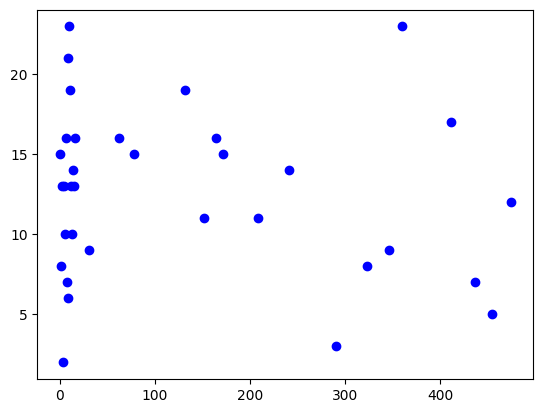

In [5]:
# Attempting to see if there are trends in the data over time.
plt.plot(team['curr_shots'], 'bo', label='Current Shots')

<Axes: >

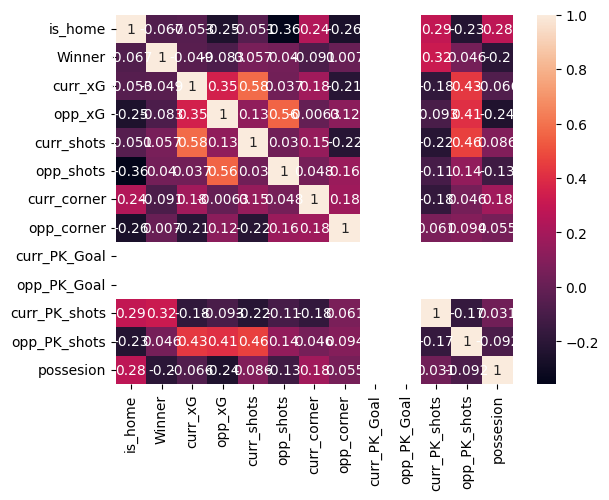

In [6]:
# Find what features are most correlated with the winner
corr = team.corr()

# Create a heatmap
sns.heatmap(corr, annot=True)

In [7]:
# Split the data into a feature matrix and a target vector
X = team
y = team['Winner']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Make sure that the data is balanced
X_train = pd.DataFrame(X_train, columns=team.columns)
X_test = pd.DataFrame(X_test, columns=team.columns)
print(X_train['Winner'].value_counts())

# Resample the data
X_train_0 = X_train[X_train['Winner'] == 0]
X_train_1 = X_train[X_train['Winner'] == 1]
samples = 1000
X_train_0_resampled = X_train_0.sample(samples, replace=True)
X_train_1_resampled = X_train_1.sample(samples, replace=True)
X_train = pd.concat([X_train_0_resampled, X_train_1_resampled], axis=0)
print(X_train['Winner'].value_counts())

X_test_0 = X_test[X_test['Winner'] == 0]
X_test_1 = X_test[X_test['Winner'] == 1]
samples = 1000
X_test_0_resampled = X_test_0.sample(samples, replace=True)
X_test_1_resampled = X_test_1.sample(samples, replace=True)
X_test = pd.concat([X_test_0_resampled, X_test_1_resampled], axis=0)

y_train = X_train['Winner'].values
X_train = X_train.drop('Winner', axis=1).values
y_test = X_test['Winner'].values 
X_test = X_test.drop('Winner', axis=1).values

Winner
False    17
True      6
Name: count, dtype: int64
Winner
False    1000
True     1000
Name: count, dtype: int64


              precision    recall  f1-score   support

       False       0.43      0.75      0.55      1000
        True       0.00      0.00      0.00      1000

    accuracy                           0.38      2000
   macro avg       0.21      0.38      0.27      2000
weighted avg       0.21      0.38      0.27      2000



<Axes: >

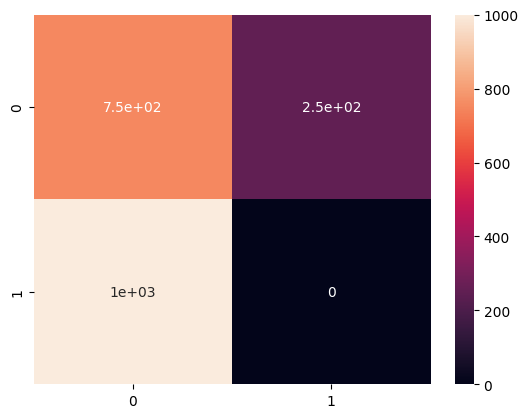

In [8]:
# Standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Create a logistic regression model
logreg = LogisticRegression()

# Fit the model
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Show the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

Tuned Logistic Regression Parameters: {'C': 1.623776739188721, 'penalty': 'l2'}
Best score is 1.0
              precision    recall  f1-score   support

       False       0.43      0.75      0.55      1000
        True       0.00      0.00      0.00      1000

    accuracy                           0.38      2000
   macro avg       0.21      0.38      0.27      2000
weighted avg       0.21      0.38      0.27      2000



<Axes: >

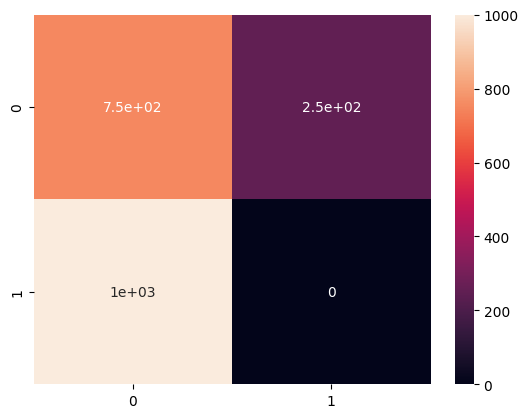

In [9]:
# Use grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.logspace(-4, 4, 20),
              'penalty': ['l2']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

# Print the best hyperparameters
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

# Make predictions
y_pred = logreg_cv.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Show the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)


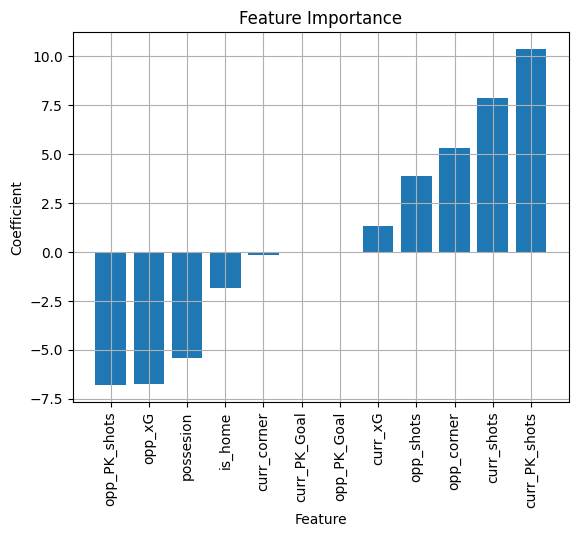

In [10]:
# Make a plot of the most important features for the logistic regression
coefficients = logreg_cv.best_estimator_.coef_
coefficients = coefficients.flatten()
features = X.drop('Winner', axis=1).columns

# Order by the magnitude of the coefficients
coefficients, features = zip(*sorted(zip(coefficients, features)))
plt.bar(features, coefficients)
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.grid()

              precision    recall  f1-score   support

       False       0.43      0.75      0.54      1000
        True       0.00      0.00      0.00      1000

    accuracy                           0.37      2000
   macro avg       0.21      0.37      0.27      2000
weighted avg       0.21      0.37      0.27      2000



<Axes: >

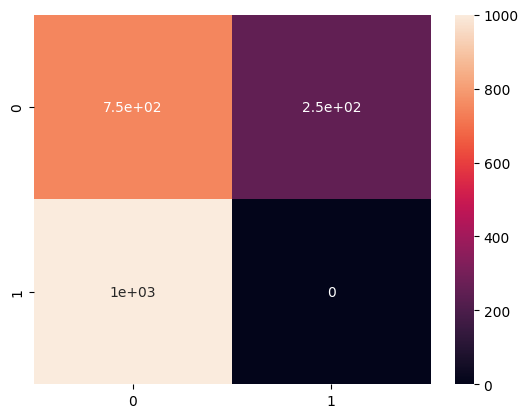

In [11]:
# Try a different model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

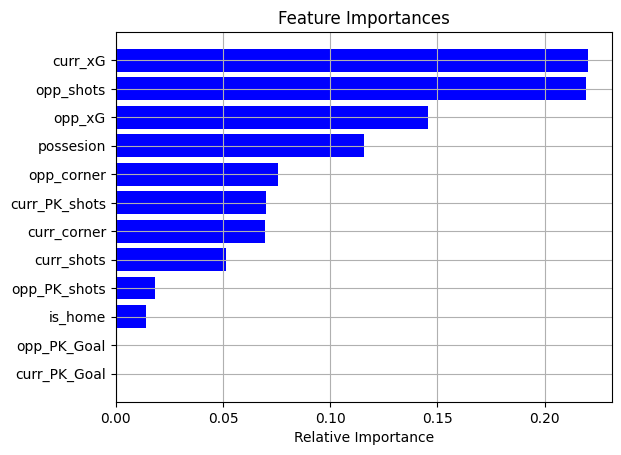

In [12]:
# Get insight about the random forest model
importances = rf.feature_importances_
features = team.drop('Winner', axis=1).columns
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()

              precision    recall  f1-score   support

       False       0.47      0.88      0.61      1000
        True       0.00      0.00      0.00      1000

    accuracy                           0.44      2000
   macro avg       0.23      0.44      0.31      2000
weighted avg       0.23      0.44      0.31      2000



<Axes: >

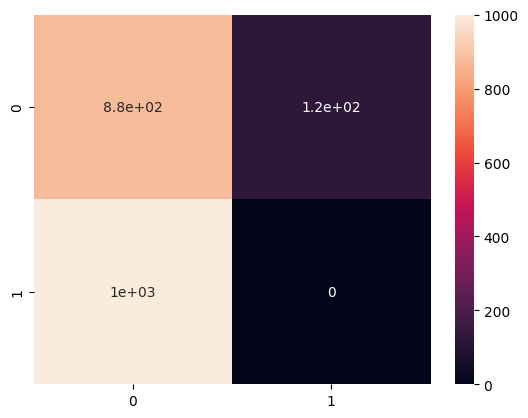

In [13]:
# Try a different model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=1.000 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=1.000 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=1.000 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=1.000 total time=   0.1s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=1.000 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=1.000 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.772 total time=   0.1s
[CV 2/5] END .................C=0.1, gamma=0.01

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

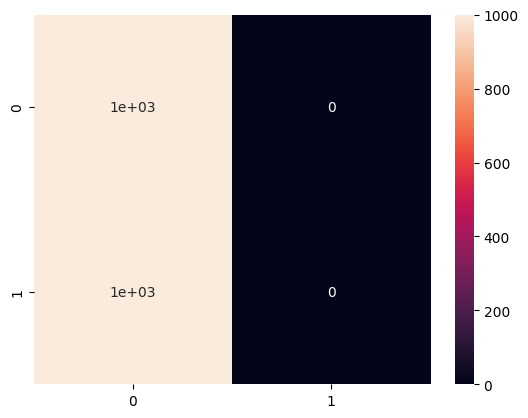

In [14]:
# Get insight about the SVC model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)
